In [5]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [7]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    smiles = []
    groups = []
    families = []
    kinases = []

    for frag in suppl:
        
        # delete dummy atoms
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # remove duplicates based on smiles
        #if s in smiles:
        #    continue
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        fragments.append(Chem.MolFromSmiles(s))
        
        groups.append(frag.GetProp('group'))
        families.append(frag.GetProp('family'))
        kinases.append(frag.GetProp('kinase'))
    
    df['fragment'] = fragments
    df['smiles'] = smiles
    df['subpocket'] = subpocket
    df['group'] = groups
    df['family'] = families
    df['kinase'] = kinases
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7197, 6)

In [8]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

In [9]:
df_AP.drop_duplicates(subset='smiles').shape

(1114, 6)

In [10]:
df_AP.smiles.nunique()

1114

In [11]:
groups = df_AP.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

Calculate number of fragments and unique fragments per kinase group per subpocket.

In [12]:
n_frags = {}
n_unique_frags = {}

for subpocket in subpockets:
    
    df = data[data.subpocket==subpocket]
    
    n_frags_group = {}
    n_unique_frags_group = {}
    
    for group in groups:
        
        df_group = df[df.group==group]
        n = df_group.shape[0]
        n_unique = df_group.smiles.nunique()
        
        n_frags_group[group] = n
        n_unique_frags_group[group] = n_unique
        
    n_frags[subpocket] = n_frags_group
    n_unique_frags[subpocket] = n_unique_frags_group


In [13]:
n_frags = pd.DataFrame(data=n_frags)
n_frags.loc["Total"] = n_frags.sum(axis=0)
n_frags["Total"] = n_frags.sum(axis=1)

In [14]:
n_unique_frags = pd.DataFrame(data=n_unique_frags)
n_unique_frags.loc["Total"] = n_unique_frags.sum(axis=0)
n_unique_frags["Total"] = n_unique_frags.sum(axis=1)

In [15]:
df_n_frags = pd.concat([n_frags,n_unique_frags], axis=1, keys=['All', 'Unique'])
df_n_frags.stack(0)

AP  B1  B2    FP    GA    SE  Total
AGC   All      137   0   2   128    21    16    304
      Unique    70   0   1   102    10    11    194
CAMK  All      368   0   1   241   127   157    894
      Unique   264   0   1   156    54   101    576
CK1   All       49   0   0    33    33    20    135
      Unique    35   0   0    22    11    15     83
CMGC  All      818   3  57   549   330   480   2237
      Unique   410   3  26   286   118   182   1025
Other All      247  10   9   193    98   209    766
      Unique   140   6   6   102    47   114    415
STE   All      113   6   0    69    51    74    313
      Unique    74   5   0    48    31    56    214
TK    All      666  42  20   552   248   501   2029
      Unique   308  13  13   313    95   264   1006
TKL   All      161  37   3   100   115   103    519
      Unique    97  18   3    58    57    70    303
Total All     2559  98  92  1865  1023  1560   7197
      Unique  1398  45  50  1087   423   813   3816

In [16]:
n_frags

,AP,FP,SE,GA,B1,B2,Total
AGC,137,128,16,21,0,2,304
CAMK,368,241,157,127,0,1,894
CK1,49,33,20,33,0,0,135
CMGC,818,549,480,330,3,57,2237
Other,247,193,209,98,10,9,766
STE,113,69,74,51,6,0,313
TK,666,552,501,248,42,20,2029
TKL,161,100,103,115,37,3,519
Total,2559,1865,1560,1023,98,92,7197


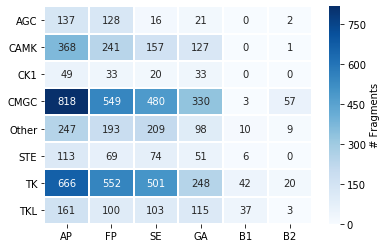

In [17]:
sns.heatmap(n_frags.drop(['Total'], axis=0).drop(['Total'], axis=1), linewidths=1, annot=True, cbar_kws={"label": "# Fragments"}, cmap="Blues", fmt='g')
plt.show()

In [18]:
groups = df_AP.group.unique()

In [19]:
# unique fragments per group per subpocket
for group in groups:
    
    df = data[data.group==group]
    n = 0
    
    for subpocket in subpockets:
        
        n_s = df[df.subpocket==subpocket].smiles.nunique()
        n += n_s
    
    print(group, n)

Other 415
TK 1006
TKL 303
AGC 194
CMGC 1025
CAMK 576
CK1 83
STE 214
